In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
from transforms_torch import bandpass_filter
plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
im_torch, im_orig, label = dset.get_im_and_label(251, device=device) # this will download the mnist dataset
model = Net().to(device)
im_torch = im_torch.to(device)
model.load_state_dict(torch.load('../../dsets/mnist/mnist.model', map_location=device))
model = model.eval().to(device)

# nmf stuff

In [23]:
mnist = datasets.MNIST('mnist/data', train=True, download=True)
X = mnist.data.numpy().astype(np.float32)
X = X.reshape(X.shape[0], -1)

In [26]:
nmf = NMF(n_components=30, random_state=42)
# nmf.fit(X)
# pkl.dump(nmf, open('nmf_30.pkl', 'wb'))
nmf = pkl.load(open('nmf_30.pkl', 'rb'))
D = nmf.components_.reshape(-1, 28, 28)
print('D.shape', D.shape)

D.shape (30, 28, 28)


In [27]:
# viz.viz_basis(D)

In [28]:
X_t = nmf.transform(X) # (n, num_bases)
D = nmf.components_ # (num_bases, input_size)
X_ = X_t @ D.astype(np.float32) # inverse transform
np.mean(np.square(X_ - X)) / np.mean(np.square(X))

0.2155938798355274

In [43]:
transform = transform_wrappers.lay_from_w(D)
norm = transform_wrappers.NormLayer(mu=0.1307, std=0.3081)
net = transform_wrappers.Net_with_transform(model, transform=transform, norm=norm).to(device)

In [30]:
x = X[:1]
x_t = nmf.transform(x)
x_t_tensor = torch.Tensor(x_t).to(device)

In [31]:
x_t_tensor.shape

torch.Size([1, 30])

In [32]:
net(x_t_tensor)

post transform torch.Size([1, 784])
pre model torch.Size([1, 1, 28, 28])
forward torch.Size([1, 1, 28, 28])
later torch.Size([1, 10])


tensor([[-1259.4615, -2353.5322, -2388.3691,  -631.3661, -2564.7568,     0.0000,
         -1632.0317, -2212.9761, -1528.3887, -1069.9989]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [44]:
list(net.modules())
for mod in net.modules():
    print(type(mod))

<class 'transform_wrappers.Net_with_transform'>
<class 'torch.nn.modules.linear.Linear'>
<class 'transform_wrappers.NormLayer'>
<class 'model.Net'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.dropout.Dropout2d'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.dropout.Dropout'>
<class 'torch.nn.modules.linear.Linear'>


In [46]:
acd.cd(im_torch=x_t_tensor, model=net, mask=np.expand_dims(tiles[0], 0), device=device)[0].data.cpu().numpy()

<class 'transform_wrappers.Net_with_transform'> torch.Size([1, 1, 30])
<class 'torch.nn.modules.linear.Linear'> torch.Size([1, 1, 30])
<class 'transform_wrappers.NormLayer'> torch.Size([1, 784])
<class 'model.Net'> torch.Size([1, 784])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 784])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 10 1 5 5, but got 2-dimensional input of size [1, 784] instead

In [100]:
x = X[:1]
x_t = nmf.transform(x)
# x_t = torch.Tensor(x_t).to(device)

In [101]:
x_t.shape

(1, 30)

In [33]:
# x.requires_grad = False
sweep_dim = 1
tiles = acd.tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=sweep_dim)
cd_scores_im = acd.get_scores_2d(net, method='cd', ims=tiles, im_torch=x_t_tensor)

  0%|          | 0/30 [00:00<?, ?it/s]


RuntimeError: Given input size: (1x1x784). Calculated output size: (1x0x392). Output size is too small

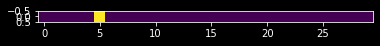

In [104]:
plt.imshow(tiles[5])

In [99]:
x_t.shape

(2, 30)